# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 7th 11:59 PM (+1 day)**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

## **Name:** Karoki Evans Njogu  
## **Neptun ID:** MFLGTK 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
!pip install wget
!pip install torch
!pip install torchvision
!pip install Pillow scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=f57f8d6df6dcba2988a4713cbd413c6481298249667c82c05d89a453721392ca
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [3]:
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz 
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz 
!wget http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
!tar -xzf cars_train.tgz 
!tar -xzf cars_test.tgz 
!tar -xzf car_devkit.tgz

--2023-04-09 10:10:45--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  44.0MB/s    in 40s     

2023-04-09 10:11:25 (23.1 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]

--2023-04-09 10:11:25--  http://ai.stanford.edu/~jkrause/car196/cars_test.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  18.7MB/s    in 42s     

2023-04-09 10:12:08 (21.9 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]

-

#### Loading the dataset
Show some images and labels of your dataset

In [4]:
def load_car_data():
    car_meta = loadmat('/content/devkit/cars_meta.mat')['class_names'][0]
    train_labels = loadmat('/content/devkit/cars_train_annos.mat')['annotations'][0]
    test_labels = loadmat('/content/devkit/cars_test_annos.mat')['annotations'][0]

    return car_meta, train_labels, test_labels

car_meta, train_labels, test_labels = load_car_data()

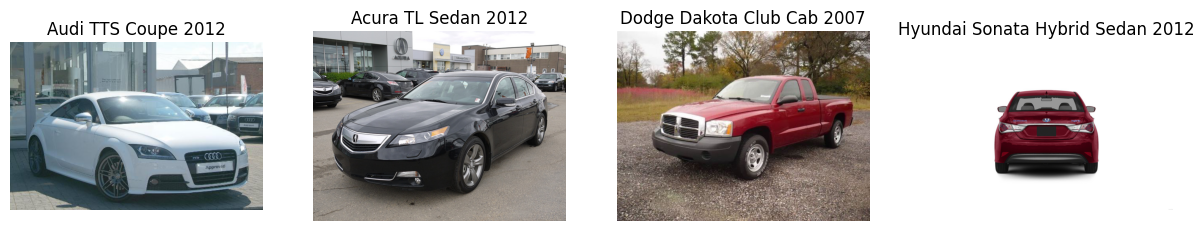

In [5]:
def show_some_images(images, labels, car_meta):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (image, label) in enumerate(zip(images, labels)):
        axes[idx].imshow(image)
        axes[idx].set_title(car_meta[label - 1][0])
        axes[idx].axis('off')
    plt.show()

images = [Image.open(f'/content/cars_train/{train_labels[i][5][0]}') for i in range(4)]
labels = [train_labels[i][4][0][0] for i in range(4)]

show_some_images(images, labels, car_meta)

#### Splitting the dataset

In [6]:
train_labels, val_labels = train_test_split(train_labels, test_size=0.2, random_state=42)

#### Pre-processing the dataset

In [7]:
class CarDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels[idx][5][0])
        image = Image.open(img_name)
        label = self.labels[idx][4][0][0] - 1

        if self.transform:
            image = self.transform(image)

        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Ensure 3-channel image
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = CarDataset(train_labels, '/content/cars_train', transform=data_transforms['train'])
val_dataset = CarDataset(val_labels, '/content/cars_train', transform=data_transforms['val'])
test_dataset = CarDataset(test_labels, '/content/cars_test', transform=data_transforms['test'])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
}

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [9]:
!export CUDA_LAUNCH_BLOCKING=1
from torchvision.models.vgg import VGG16_Weights

num_classes = len(car_meta)

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

#### Define your optimizer and loss function

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
import torch

if torch.cuda.is_available():
    print(f"Using {torch.cuda.get_device_name()}")

    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.memory_allocated(i)/1024**2:.2f} MB allocated")

Using Tesla T4
Device 0: 516.10 MB allocated


#### Train your network

In [12]:
import time
import copy


def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Add lists to store loss and accuracy history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save loss and accuracy values to history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model and history
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [13]:
trained_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25)

Epoch 0/24
----------
train Loss: 5.1342 Acc: 0.0186
val Loss: 4.4843 Acc: 0.0675

Epoch 1/24
----------
train Loss: 4.3847 Acc: 0.0800
val Loss: 3.6292 Acc: 0.1553

Epoch 2/24
----------
train Loss: 3.7499 Acc: 0.1457
val Loss: 2.9486 Acc: 0.2634

Epoch 3/24
----------
train Loss: 3.2809 Acc: 0.2310
val Loss: 2.4373 Acc: 0.3732

Epoch 4/24
----------
train Loss: 2.9378 Acc: 0.2832
val Loss: 2.1156 Acc: 0.4316

Epoch 5/24
----------
train Loss: 2.6549 Acc: 0.3412
val Loss: 2.0229 Acc: 0.4586

Epoch 6/24
----------
train Loss: 2.3825 Acc: 0.3986
val Loss: 1.6460 Acc: 0.5371

Epoch 7/24
----------
train Loss: 1.9218 Acc: 0.5007
val Loss: 1.2458 Acc: 0.6304

Epoch 8/24
----------
train Loss: 1.7837 Acc: 0.5398
val Loss: 1.1973 Acc: 0.6611

Epoch 9/24
----------
train Loss: 1.7263 Acc: 0.5489
val Loss: 1.1486 Acc: 0.6605

Epoch 10/24
----------
train Loss: 1.6668 Acc: 0.5630
val Loss: 1.1215 Acc: 0.6691

Epoch 11/24
----------
train Loss: 1.5994 Acc: 0.5759
val Loss: 1.0824 Acc: 0.6753

Ep

#### Show results (accuracy and loss) on training and validation sets

In [14]:
torch.save(trained_model.state_dict(), '/content/model')

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

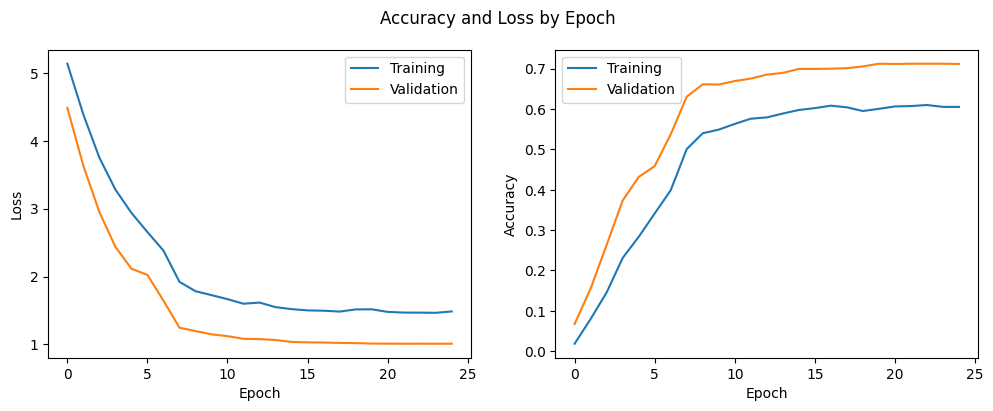

In [15]:
import matplotlib.pyplot as plt
import torch

# Define the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Accuracy and Loss by Epoch')

# Plot the training and validation loss history
axs[0].plot(torch.Tensor(train_loss_history).cpu(), label='Training')
axs[0].plot(torch.Tensor(val_loss_history).cpu(), label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation accuracy history
axs[1].plot(torch.Tensor(train_acc_history).cpu(), label='Training')
axs[1].plot(torch.Tensor(val_acc_history).cpu(), label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Show the plot
plt.show()

#### Show some predictions

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

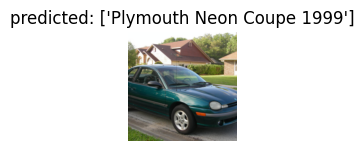

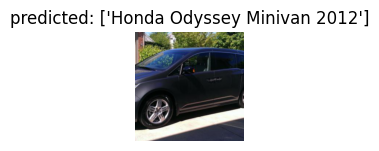

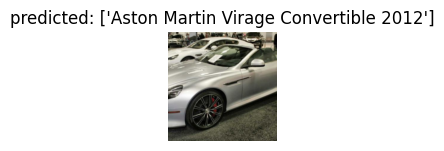

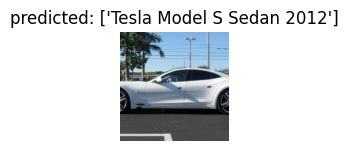

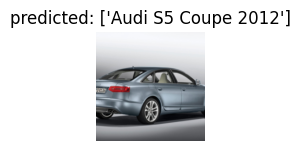

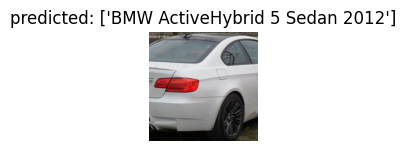

In [17]:
def visualize_model(model, dataloader, device, class_names, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

visualize_model(trained_model, dataloaders['val'], device, car_meta)
plt.ioff()
plt.show()

#### Answer the questions

The results look promising with a maximum validation accuracy of 71.21%. The training and validation losses are decreasing consistenly over the epochs, which indicates that the model is learning and improving its perfomance. There is also a small difference in training and validation accuracy which means it is not largely overfitting. Overall, the results are good, but some further fine-tuning of the model may improve the performance.

Citation:

       3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
       [pdf]   [BibTex]   [slides]
